# Model Zoo Training - Specialized PPE Detectors

**Project:** Safety Compliance Monitoring (SCM)

**Date:** January 2026

**Objective:** Train specialized single-class detectors for Model Zoo approach
- Each model detects ONE class only (binary: object vs background)
- No class imbalance issues!
- Better bbox quality per class
- Faster iteration and improvement

**Usage:**
- Auto-labeling: Use all models together (high quality)
- Deployment: Train single model on clean data from Model Zoo

## 1. Environment Setup

In [1]:
# Install dependencies
!pip install ultralytics roboflow opencv-python matplotlib seaborn pandas

import ultralytics
print(f"Ultralytics version: {ultralytics.__version__}")

from ultralytics import YOLO
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 170.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 148.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 235.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 131.5 MB/s eta 0:00:00
   ━━━━━━

In [2]:
# Set up directories
import os
from pathlib import Path
import json
import shutil
from datetime import datetime

base_dir = Path.home() / 'optense' / 'scm'
models_dir = base_dir / 'models' / 'zoo'
datasets_dir = base_dir / 'datasets' / 'zoo'
results_dir = base_dir / 'training_results' / 'model_zoo'

for dir_path in [models_dir, datasets_dir, results_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"✓ Base directory: {base_dir}")
print(f"✓ Models will be saved to: {models_dir}")
print(f"✓ Training results: {results_dir}")

✓ Base directory: /root/optense/scm
✓ Models will be saved to: /root/optense/scm/models/zoo
✓ Training results: /root/optense/scm/training_results/model_zoo


## 2. Model Zoo Configuration

In [3]:
# ============================================
# ROBOFLOW CONFIGURATION
# ============================================

ROBOFLOW_API_KEY = "Xp2CBnbQfijsteBmE2Op"  # From: https://app.roboflow.com/settings/api
WORKSPACE_NAME = "optense"

# ============================================
# MODEL ZOO CONFIGURATION
# ============================================

MODEL_CONFIGS = {
    # Priority 1: Foundation model
    'person': {
        'project': 'aa-person',
        'version': 1,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.30,  # For inference/auto-labeling
        'priority': 1,
        'description': 'Detect persons - foundation for all PPE checks',
    },
    'head': {
        'project': 'aa-head',
        'version': 1,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.30,  # For inference/auto-labeling
        'priority': 1,
        'description': 'Detect heads - foundation for all PPE checks',
    },
    'hand': {
        'project': 'aa-hand',
        'version': 1,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.30,  # For inference/auto-labeling
        'priority': 1,
        'description': 'Detect hands - foundation for all PPE checks',
    },
    'face': {
        'project': 'aa-face',
        'version': 3,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.30,  # For inference/auto-labeling
        'priority': 1,
        'description': 'Detect faces - foundation for all PPE checks',
    },
    
    # Priority 2: Common critical PPE
    'hardhat': {
        'project': 'aa-hardhat',
        'version': 3,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.40,
        'priority': 2,
        'description': 'Detect hardhats - critical PPE',
    },
    
    'gloves': {
        'project': 'aa-gloves',
        'version': 2,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.35,
        'priority': 2,
        'description': 'Detect gloves - critical PPE',
    },
    
    'shoes': {
        'project': 'aa-shoes',
        'version': 2,
        'epochs': 100,
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.40,
        'priority': 2,
        'description': 'Detect safety shoes - critical PPE',
    },
    
    # Priority 3: Medium-frequency PPE
    'safetyvest': {
        'project': 'aa-safetyvest',
        'version': 3,
        'epochs': 120,  # Slightly more for medium-frequency
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.35,
        'priority': 3,
        'description': 'Detect safety vests',
    },
    'safetysuit': {
        'project': 'aa-safetysuit',
        'version': 4,
        'epochs': 120,  # Slightly more for medium-frequency
        'batch': 16,
        'patience': 15,
        'conf_threshold': 0.35,
        'priority': 3,
        'description': 'Detect safety suits',
    },
    
    # Priority 4: Rare
    'foot': {
        'project': 'aa-foot',
        'version': 2,
        'epochs': 150,  # More epochs for rare class
        'batch': 16,
        'patience': 20,  # More patience for rare class
        'conf_threshold': 0.25,  # Lower threshold (rare = harder to detect)
        'priority': 4,
        'description': 'Detect foot - rare class',
    },
}

# Training order (by priority)
TRAINING_ORDER = sorted(
    MODEL_CONFIGS.keys(),
    key=lambda x: MODEL_CONFIGS[x]['priority']
)

print("Model Zoo Configuration:")
print(f"  Total models: {len(MODEL_CONFIGS)}")
print(f"  Training order: {TRAINING_ORDER}")
print("\nModels to train:")
for i, class_name in enumerate(TRAINING_ORDER, 1):
    config = MODEL_CONFIGS[class_name]
    print(f"  {i}. {class_name:12s} - {config['description']}")

Model Zoo Configuration:
  Total models: 10
  Training order: ['person', 'head', 'hand', 'face', 'hardhat', 'gloves', 'shoes', 'safetyvest', 'safetysuit', 'foot']

Models to train:
  1. person       - Detect persons - foundation for all PPE checks
  2. head         - Detect heads - foundation for all PPE checks
  3. hand         - Detect hands - foundation for all PPE checks
  4. face         - Detect faces - foundation for all PPE checks
  5. hardhat      - Detect hardhats - critical PPE
  6. gloves       - Detect gloves - critical PPE
  7. shoes        - Detect safety shoes - critical PPE
  8. safetyvest   - Detect safety vests
  9. safetysuit   - Detect safety suits
  10. foot         - Detect foot - rare class


## 3. Download Datasets from Roboflow

In [4]:
from roboflow import Roboflow

# Initialize Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
print("✓ Roboflow initialized")

# Download all datasets
downloaded_datasets = {}

for class_name in TRAINING_ORDER:
    config = MODEL_CONFIGS[class_name]
    
    print(f"\n{'='*60}")
    print(f"Downloading: {class_name} dataset")
    print(f"{'='*60}")
    print(f"Project: {config['project']}")
    print(f"Version: {config['version']}")
    
    try:
        project = rf.workspace(WORKSPACE_NAME).project(config['project'])
        dataset = project.version(config['version']).download(
            'yolov8',
            location=str(datasets_dir / class_name)
        )
        
        downloaded_datasets[class_name] = {
            'location': dataset.location,
            'data_yaml': Path(dataset.location) / 'data.yaml'
        }
        
        print(f"✓ Downloaded to: {dataset.location}")
        
    except Exception as e:
        print(f"❌ Error downloading {class_name}: {e}")
        print(f"   Skipping this model...")

print(f"\n{'='*60}")
print(f"Downloaded {len(downloaded_datasets)}/{len(MODEL_CONFIGS)} datasets")
print(f"{'='*60}")

✓ Roboflow initialized

Downloading: person dataset
Project: aa-person
Version: 1
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/person in yolov8:: 100%|██████████| 36430/36430 [00:03<00:00, 9467.72it/s] 


✓ Downloaded to: /root/optense/scm/datasets/zoo/person

Downloading: head dataset
Project: aa-head
Version: 1
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/head in yolov8:: 100%|██████████| 31210/31210 [00:03<00:00, 9584.43it/s] 


✓ Downloaded to: /root/optense/scm/datasets/zoo/head

Downloading: hand dataset
Project: aa-hand
Version: 1
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/hand in yolov8:: 100%|██████████| 30866/30866 [00:03<00:00, 9667.56it/s] 


✓ Downloaded to: /root/optense/scm/datasets/zoo/hand

Downloading: face dataset
Project: aa-face
Version: 3
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/face in yolov8:: 100%|██████████| 27146/27146 [00:02<00:00, 9746.68it/s] 

✓ Downloaded to: /root/optense/scm/datasets/zoo/face

Downloading: hardhat dataset
Project: aa-hardhat
Version: 3
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/hardhat in yolov8:: 100%|██████████| 4880/4880 [00:00<00:00, 9425.45it/s] 

✓ Downloaded to: /root/optense/scm/datasets/zoo/hardhat

Downloading: gloves dataset
Project: aa-gloves
Version: 2
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/gloves in yolov8:: 100%|██████████| 6192/6192 [00:00<00:00, 9708.42it/s] 

✓ Downloaded to: /root/optense/scm/datasets/zoo/gloves

Downloading: shoes dataset
Project: aa-shoes
Version: 2
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/shoes in yolov8:: 100%|██████████| 8430/8430 [00:00<00:00, 9093.89it/s] 

✓ Downloaded to: /root/optense/scm/datasets/zoo/shoes

Downloading: safetyvest dataset
Project: aa-safetyvest
Version: 3
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/safetyvest in yolov8:: 100%|██████████| 2238/2238 [00:00<00:00, 9530.36it/s]

✓ Downloaded to: /root/optense/scm/datasets/zoo/safetyvest

Downloading: safetysuit dataset
Project: aa-safetysuit
Version: 4
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/safetysuit in yolov8:: 100%|██████████| 1482/1482 [00:00<00:00, 8322.37it/s]


✓ Downloaded to: /root/optense/scm/datasets/zoo/safetysuit

Downloading: foot dataset
Project: aa-foot
Version: 2
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /root/optense/scm/datasets/zoo/foot in yolov8:: 100%|██████████| 3610/3610 [00:00<00:00, 9368.22it/s]

✓ Downloaded to: /root/optense/scm/datasets/zoo/foot

Downloaded 10/10 datasets


## 4. Inspect Datasets

In [7]:
import yaml
from collections import Counter
import matplotlib.pyplot as plt

def inspect_single_class_dataset(data_yaml_path, class_name):
    """Inspect single-class dataset."""
    
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    dataset_root = Path(data_yaml_path).parent
    
    print(f"\n{'='*50}")
    print(f"Dataset: {class_name}")
    print(f"{'='*50}")
    print(f"Classes: {data['nc']} ({data['names']})")
    
    # Count images
    train_images = list((dataset_root / data['train']).glob('*.jpg')) + \
                   list((dataset_root / data['train']).glob('*.png'))
    val_images = list((dataset_root / data['val']).glob('*.jpg')) + \
                 list((dataset_root / data['val']).glob('*.png'))
    
    print(f"\nImage counts:")
    print(f"  Train: {len(train_images)}")
    print(f"  Val: {len(val_images)}")
    print(f"  Total: {len(train_images) + len(val_images)}")
    
    # Count positive vs negative samples
    train_labels_dir = dataset_root / data['train'].replace('images', 'labels')
    
    positive_samples = 0
    negative_samples = 0
    total_annotations = 0
    
    for img_file in train_images:
        label_file = train_labels_dir / f"{img_file.stem}.txt"
        
        if label_file.exists():
            with open(label_file) as f:
                lines = f.readlines()
                if lines:
                    positive_samples += 1
                    total_annotations += len(lines)
                else:
                    negative_samples += 1
        else:
            negative_samples += 1
    
    print(f"\nAnnotation breakdown:")
    print(f"  Positive samples: {positive_samples} (images with {class_name})")
    print(f"  Negative samples: {negative_samples} (images without {class_name})")
    print(f"  Total annotations: {total_annotations}")
    
    if positive_samples > 0:
        ratio = negative_samples / positive_samples
        print(f"  Negative:Positive ratio: {ratio:.2f}:1")
    
    return {
        'class_name': class_name,
        'train_images': len(train_images),
        'val_images': len(val_images),
        'positive_samples': positive_samples,
        'negative_samples': negative_samples,
        'total_annotations': total_annotations,
    }

# Inspect all datasets
dataset_stats = {}

for class_name, dataset_info in downloaded_datasets.items():
    stats = inspect_single_class_dataset(
        dataset_info['data_yaml'],
        class_name
    )
    dataset_stats[class_name] = stats

print(f"\n{'='*60}")
print("Dataset Inspection Complete")
print(f"{'='*60}")


Dataset: person
Classes: 1 (['person'])

Image counts:
  Train: 15891
  Val: 1542
  Total: 17433

Annotation breakdown:
  Positive samples: 15890 (images with person)
  Negative samples: 1 (images without person)
  Total annotations: 28376
  Negative:Positive ratio: 0.00:1

Dataset: head
Classes: 1 (['head'])

Image counts:
  Train: 13650
  Val: 1303
  Total: 14953

Annotation breakdown:
  Positive samples: 13641 (images with head)
  Negative samples: 9 (images without head)
  Total annotations: 24895
  Negative:Positive ratio: 0.00:1

Dataset: hand
Classes: 1 (['hand'])

Image counts:
  Train: 13464
  Val: 1308
  Total: 14772

Annotation breakdown:
  Positive samples: 13449 (images with hand)
  Negative samples: 15 (images without hand)
  Total annotations: 32846
  Negative:Positive ratio: 0.00:1

Dataset: face
Classes: 1 (['face'])

Image counts:
  Train: 11883
  Val: 1115
  Total: 12998

Annotation breakdown:
  Positive samples: 11868 (images with face)
  Negative samples: 15 (imag

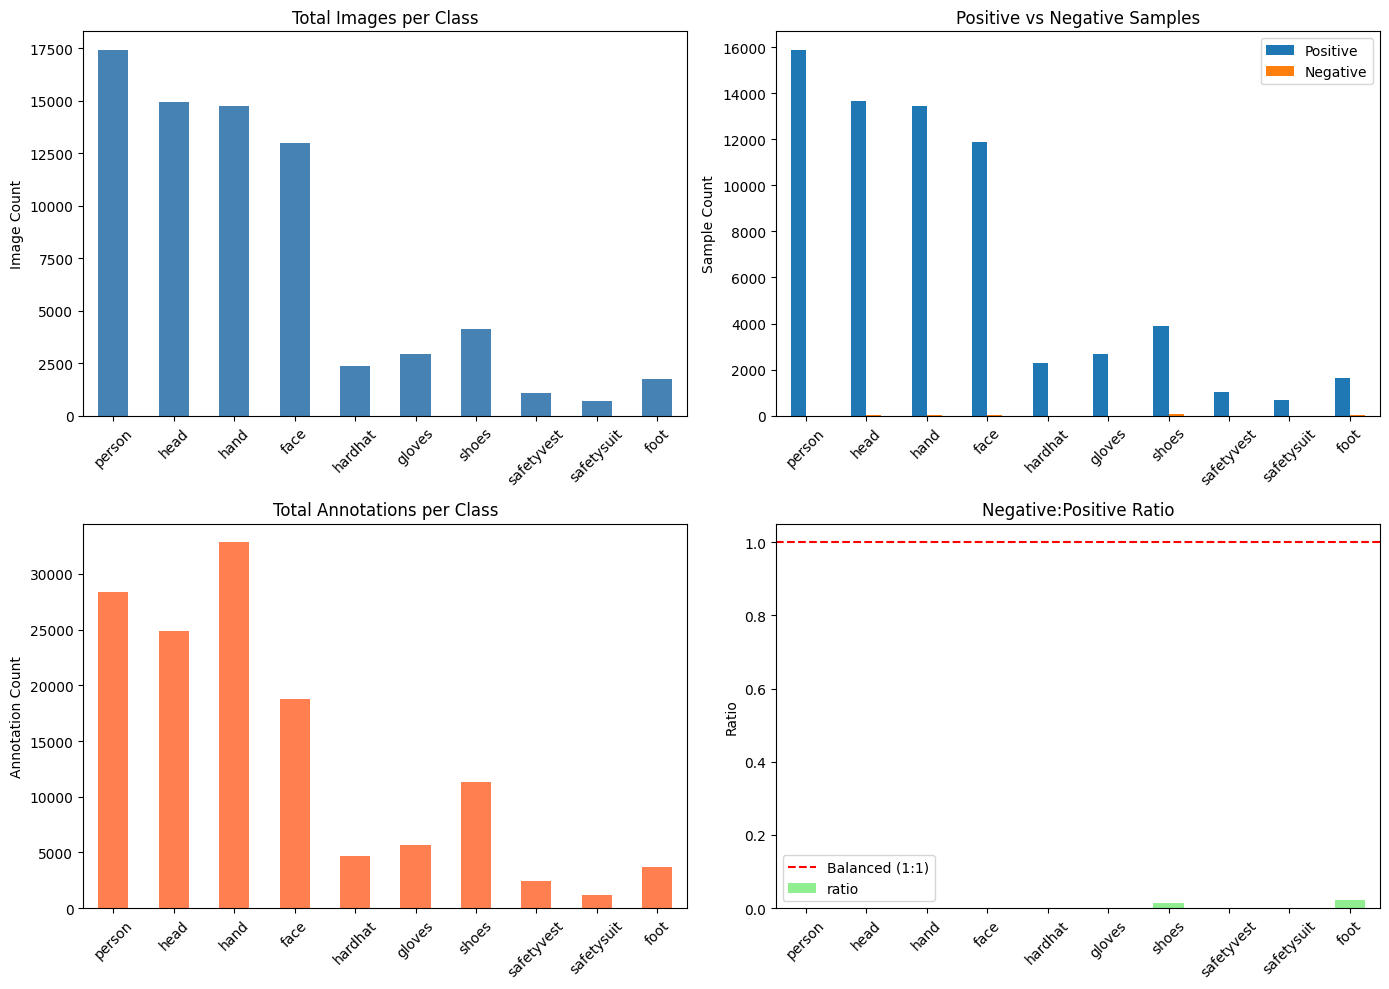


✓ Statistics saved to: /root/optense/scm/training_results/model_zoo/dataset_statistics.png


In [8]:
# Visualize dataset statistics
import pandas as pd

df = pd.DataFrame(dataset_stats).T

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Total images per class
df['total_images'] = df['train_images'] + df['val_images']
df['total_images'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Total Images per Class')
axes[0, 0].set_ylabel('Image Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Positive vs Negative samples
df[['positive_samples', 'negative_samples']].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Positive vs Negative Samples')
axes[0, 1].set_ylabel('Sample Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(['Positive', 'Negative'])

# Plot 3: Total annotations
df['total_annotations'].plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Total Annotations per Class')
axes[1, 0].set_ylabel('Annotation Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Negative:Positive ratio
df['ratio'] = df['negative_samples'] / df['positive_samples']
df['ratio'].plot(kind='bar', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Negative:Positive Ratio')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=1, color='r', linestyle='--', label='Balanced (1:1)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(results_dir / 'dataset_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Statistics saved to: {results_dir / 'dataset_statistics.png'}")

## 5. Training Configuration

In [9]:
def get_training_config(class_name, data_yaml_path):
    """
    Get training configuration for specific class.
    """
    
    config = MODEL_CONFIGS[class_name]
    
    training_config = {
        'data': str(data_yaml_path),
        'epochs': config['epochs'],
        'batch': config['batch'],
        'imgsz': 640,
        'patience': config['patience'],
        'save': True,
        'save_period': 10,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'workers': 8,
        'project': str(results_dir),
        'name': f'{class_name}_v1',
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'AdamW',
        'verbose': True,
        'seed': 42,
        'single_cls': True,  # CRITICAL: Binary classification mode!
        
        # Learning rates
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        
        # Loss weights
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        
        # Augmentation (already done in Roboflow, but add some)
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 0.0,  # Rotation done in Roboflow
        'translate': 0.1,
        'scale': 0.5,
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.0,
        'copy_paste': 0.0,
        
        # Validation
        'cos_lr': True,
        'close_mosaic': 10,
        'resume': False,
        'amp': True,
        'fraction': 1.0,
        'plots': True,
        'val': True,
    }
    
    return training_config

print("✓ Training configuration ready")
print(f"  Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"  Single-class mode: Enabled")
print(f"  Batch size: {MODEL_CONFIGS[TRAINING_ORDER[0]]['batch']}")

✓ Training configuration ready
  Device: GPU
  Single-class mode: Enabled
  Batch size: 16


## 6. Train All Models

In [10]:
# Training tracker
training_results = {}
training_log = []

print("="*70)
print("STARTING MODEL ZOO TRAINING")
print("="*70)
print(f"Models to train: {len(downloaded_datasets)}")
print(f"Estimated time: {len(downloaded_datasets) * 45} minutes ({len(downloaded_datasets) * 0.75:.1f} hours)")
print(f"Training order: {' → '.join(TRAINING_ORDER)}")
print("")
print("You can monitor progress in real-time!")
print("Each model takes ~30-60 minutes depending on dataset size.")
print("="*70)

start_time = datetime.now()

for idx, class_name in enumerate(TRAINING_ORDER, 1):
    if class_name not in downloaded_datasets:
        print(f"\n⚠️  Skipping {class_name} (dataset not downloaded)")
        continue
    
    print(f"\n\n{'='*70}")
    print(f"TRAINING MODEL {idx}/{len(downloaded_datasets)}: {class_name.upper()}")
    print(f"{'='*70}")
    
    config = MODEL_CONFIGS[class_name]
    dataset_info = downloaded_datasets[class_name]
    
    print(f"Description: {config['description']}")
    print(f"Priority: {config['priority']}")
    print(f"Epochs: {config['epochs']}")
    print(f"Confidence threshold (for inference): {config['conf_threshold']}")
    print(f"Dataset: {dataset_stats[class_name]['train_images']} train, {dataset_stats[class_name]['val_images']} val")
    print(f"Positive samples: {dataset_stats[class_name]['positive_samples']}")
    print("")
    
    model_start = datetime.now()
    
    try:
        # Initialize model
        model = YOLO('yolov8n.pt')
        
        # Get training config
        train_config = get_training_config(class_name, dataset_info['data_yaml'])
        
        # Train
        print(f"Starting training for {class_name}...\n")
        results = model.train(**train_config)
        
        model_end = datetime.now()
        duration = (model_end - model_start).total_seconds() / 60
        
        # Extract metrics
        try:
            final_metrics = {
                'mAP50': float(results.results_dict.get('metrics/mAP50(B)', 0)),
                'mAP50-95': float(results.results_dict.get('metrics/mAP50-95(B)', 0)),
                'precision': float(results.results_dict.get('metrics/precision(B)', 0)),
                'recall': float(results.results_dict.get('metrics/recall(B)', 0)),
            }
        except:
            # Fallback if metrics not available
            final_metrics = {
                'mAP50': 0.0,
                'mAP50-95': 0.0,
                'precision': 0.0,
                'recall': 0.0,
            }
        
        # Find best weights
        best_weights = list((results_dir / f'{class_name}_v1').glob('**/weights/best.pt'))[0]
        
        # Save to model zoo
        model_save_path = models_dir / f'{class_name}_v1.pt'
        shutil.copy(best_weights, model_save_path)
        
        # Save metadata
        metadata = {
            'class': class_name,
            'version': 'v1',
            'trained_at': datetime.now().isoformat(),
            'duration_minutes': round(duration, 1),
            'metrics': final_metrics,
            'conf_threshold': config['conf_threshold'],
            'dataset': {
                'project': config['project'],
                'version': config['version'],
                'train_images': dataset_stats[class_name]['train_images'],
                'positive_samples': dataset_stats[class_name]['positive_samples'],
            },
            'training_config': {
                'epochs': config['epochs'],
                'batch': config['batch'],
                'patience': config['patience'],
            },
        }
        
        with open(model_save_path.with_suffix('.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        training_results[class_name] = {
            'status': 'success',
            'metrics': final_metrics,
            'duration': duration,
            'model_path': str(model_save_path),
        }
        
        print(f"\n{'='*70}")
        print(f"✓ {class_name.upper()} TRAINING COMPLETE!")
        print(f"{'='*70}")
        print(f"Duration: {duration:.1f} minutes")
        print(f"mAP50: {final_metrics['mAP50']:.4f}")
        print(f"mAP50-95: {final_metrics['mAP50-95']:.4f}")
        print(f"Precision: {final_metrics['precision']:.4f}")
        print(f"Recall: {final_metrics['recall']:.4f}")
        print(f"Model saved: {model_save_path}")
        print(f"Metadata saved: {model_save_path.with_suffix('.json')}")
        
        # Log
        log_entry = f"[{datetime.now().strftime('%H:%M:%S')}] ✓ {class_name}: mAP50={final_metrics['mAP50']:.3f}, {duration:.1f}min"
        training_log.append(log_entry)
        
    except Exception as e:
        print(f"\n❌ ERROR training {class_name}: {e}")
        training_results[class_name] = {
            'status': 'failed',
            'error': str(e),
        }
        log_entry = f"[{datetime.now().strftime('%H:%M:%S')}] ❌ {class_name}: FAILED - {e}"
        training_log.append(log_entry)

end_time = datetime.now()
total_duration = (end_time - start_time).total_seconds() / 60

print("\n\n" + "="*70)
print("MODEL ZOO TRAINING COMPLETE!")
print("="*70)
print(f"Total time: {total_duration:.1f} minutes ({total_duration/60:.1f} hours)")
print(f"Models trained: {sum(1 for r in training_results.values() if r['status'] == 'success')}/{len(downloaded_datasets)}")
print(f"Models saved in: {models_dir}")
print("\nTraining log:")
for entry in training_log:
    print(f"  {entry}")

STARTING MODEL ZOO TRAINING
Models to train: 10
Estimated time: 450 minutes (7.5 hours)
Training order: person → head → hand → face → hardhat → gloves → shoes → safetyvest → safetysuit → foot

You can monitor progress in real-time!
Each model takes ~30-60 minutes depending on dataset size.


TRAINING MODEL 1/10: PERSON
Description: Detect persons - foundation for all PPE checks
Priority: 1
Epochs: 100
Confidence threshold (for inference): 0.3
Dataset: 15891 train, 1542 val
Positive samples: 15890

Starting training for person...

Ultralytics 8.3.252 🚀 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5090, 32109MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/root/optense/scm/datasets/zoo/person/data.yaml, degrees=0.0, deterministic=True, device=0, dfl

## 7. Results Summary

In [11]:
# Create results summary
summary_data = []

for class_name in TRAINING_ORDER:
    if class_name in training_results and training_results[class_name]['status'] == 'success':
        result = training_results[class_name]
        summary_data.append({
            'Class': class_name,
            'mAP50': result['metrics']['mAP50'],
            'mAP50-95': result['metrics']['mAP50-95'],
            'Precision': result['metrics']['precision'],
            'Recall': result['metrics']['recall'],
            'Duration (min)': result['duration'],
            'Train Samples': dataset_stats[class_name]['positive_samples'],
        })

results_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("MODEL ZOO RESULTS SUMMARY")
print("="*70)
print(results_df.to_string(index=False))

# Save to CSV
results_csv = results_dir / 'model_zoo_results.csv'
results_df.to_csv(results_csv, index=False)
print(f"\n✓ Results saved to: {results_csv}")


MODEL ZOO RESULTS SUMMARY
     Class    mAP50  mAP50-95  Precision   Recall  Duration (min)  Train Samples
    person 0.848572  0.636550   0.906942 0.783802      123.488297          15890
      head 0.869843  0.655081   0.939378 0.812598       75.546643          13641
      hand 0.818438  0.537182   0.888787 0.738965      100.304892          13449
      face 0.921110  0.673424   0.961897 0.875000       88.564440          11868
   hardhat 0.724353  0.455625   0.902816 0.670330       14.385854           2294
    gloves 0.398398  0.210263   0.567491 0.361872       18.459465           2698
     shoes 0.569461  0.306005   0.751305 0.521563       29.609071           3902
safetyvest 0.395570  0.201936   0.593355 0.392031        4.637740           1049
safetysuit 0.648169  0.314757   0.826634 0.557692        5.318473            693
      foot 0.276885  0.125270   0.531769 0.253247       18.325239           1658

✓ Results saved to: /root/optense/scm/training_results/model_zoo/model_zoo_result

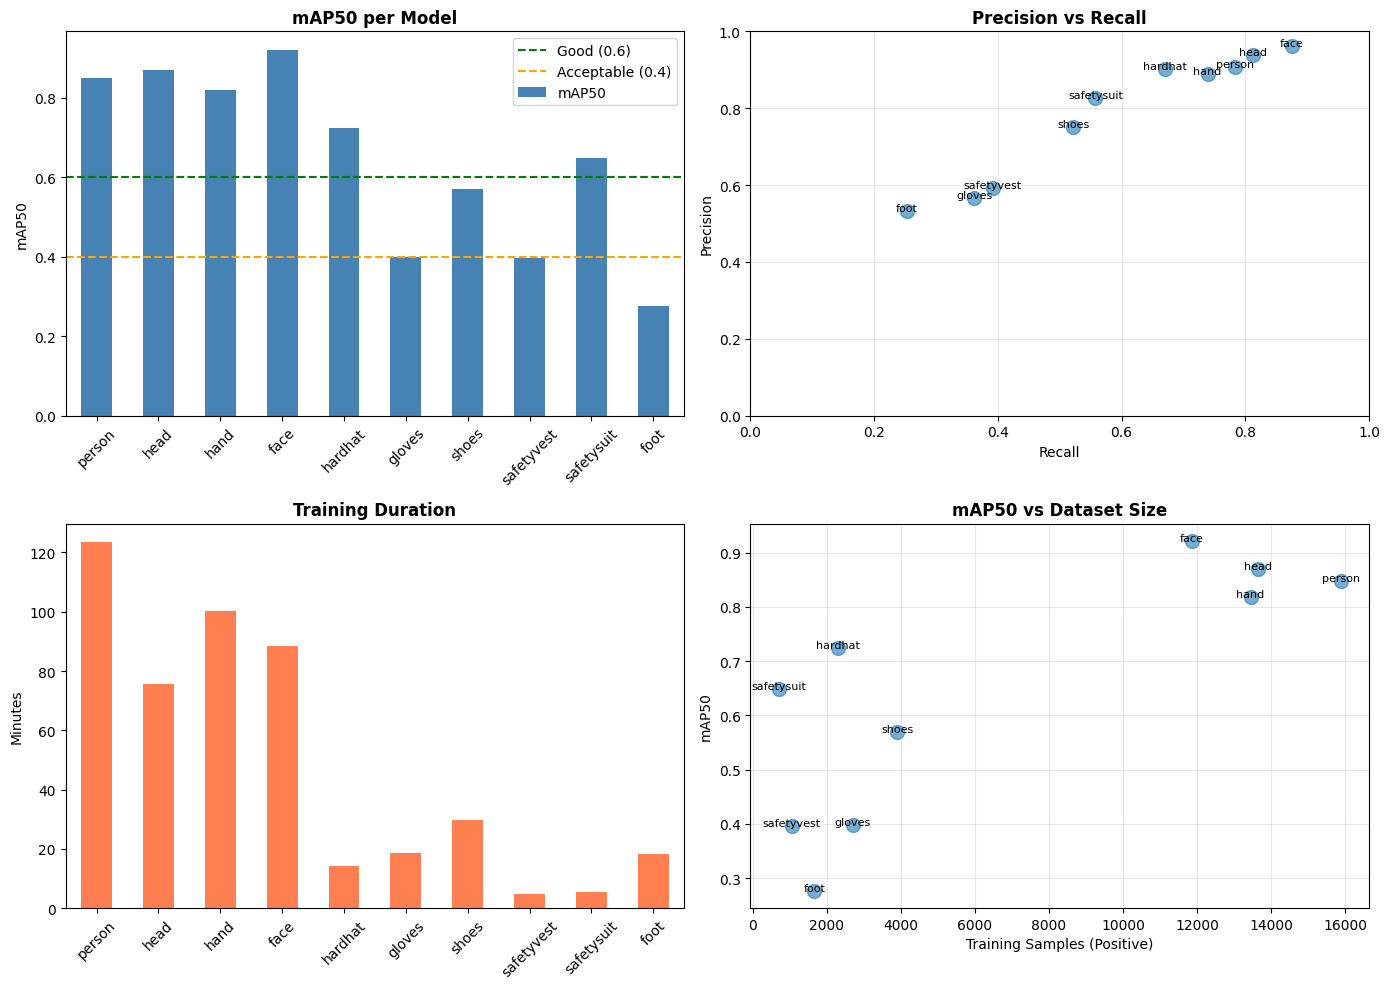

✓ Results visualization saved to: /root/optense/scm/training_results/model_zoo/model_zoo_results.png


In [12]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: mAP50 per model
results_df.plot(x='Class', y='mAP50', kind='bar', ax=axes[0, 0], color='steelblue', legend=False)
axes[0, 0].set_title('mAP50 per Model', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('mAP50')
axes[0, 0].set_xlabel('')
axes[0, 0].axhline(y=0.6, color='g', linestyle='--', label='Good (0.6)')
axes[0, 0].axhline(y=0.4, color='orange', linestyle='--', label='Acceptable (0.4)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Precision vs Recall
axes[0, 1].scatter(results_df['Recall'], results_df['Precision'], s=100, alpha=0.6)
for idx, row in results_df.iterrows():
    axes[0, 1].annotate(row['Class'], (row['Recall'], row['Precision']), 
                       fontsize=8, ha='center')
axes[0, 1].set_title('Precision vs Recall', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])

# Plot 3: Training duration
results_df.plot(x='Class', y='Duration (min)', kind='bar', ax=axes[1, 0], color='coral', legend=False)
axes[1, 0].set_title('Training Duration', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Minutes')
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: mAP vs Dataset Size
axes[1, 1].scatter(results_df['Train Samples'], results_df['mAP50'], s=100, alpha=0.6)
for idx, row in results_df.iterrows():
    axes[1, 1].annotate(row['Class'], (row['Train Samples'], row['mAP50']), 
                       fontsize=8, ha='center')
axes[1, 1].set_title('mAP50 vs Dataset Size', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Training Samples (Positive)')
axes[1, 1].set_ylabel('mAP50')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'model_zoo_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Results visualization saved to: {results_dir / 'model_zoo_results.png'}")

## 8. Model Zoo Inventory

In [13]:
# Create Model Zoo inventory
print("\n" + "="*70)
print("MODEL ZOO INVENTORY")
print("="*70)
print(f"Location: {models_dir}")
print("\nAvailable models:")

zoo_inventory = []

for model_file in sorted(models_dir.glob('*.pt')):
    metadata_file = model_file.with_suffix('.json')
    
    if metadata_file.exists():
        with open(metadata_file) as f:
            metadata = json.load(f)
        
        print(f"\n  ✓ {metadata['class']:12s} (v{metadata['version'][1:]})")
        print(f"    Model: {model_file.name}")
        print(f"    mAP50: {metadata['metrics']['mAP50']:.3f}")
        print(f"    Confidence threshold: {metadata['conf_threshold']}")
        print(f"    Trained: {metadata['trained_at'][:10]}")
        print(f"    Duration: {metadata['duration_minutes']:.1f} min")
        
        zoo_inventory.append({
            'class': metadata['class'],
            'version': metadata['version'],
            'model_path': str(model_file),
            'metadata_path': str(metadata_file),
            'mAP50': metadata['metrics']['mAP50'],
            'conf_threshold': metadata['conf_threshold'],
        })

# Save inventory
inventory_file = models_dir / 'zoo_inventory.json'
with open(inventory_file, 'w') as f:
    json.dump(zoo_inventory, f, indent=2)

print(f"\n{'='*70}")
print(f"Total models in zoo: {len(zoo_inventory)}")
print(f"Inventory saved to: {inventory_file}")
print(f"{'='*70}")


MODEL ZOO INVENTORY
Location: /root/optense/scm/models/zoo

Available models:

  ✓ face         (v1)
    Model: face_v1.pt
    mAP50: 0.921
    Confidence threshold: 0.3
    Trained: 2026-01-12
    Duration: 88.6 min

  ✓ foot         (v1)
    Model: foot_v1.pt
    mAP50: 0.277
    Confidence threshold: 0.25
    Trained: 2026-01-12
    Duration: 18.3 min

  ✓ gloves       (v1)
    Model: gloves_v1.pt
    mAP50: 0.398
    Confidence threshold: 0.35
    Trained: 2026-01-12
    Duration: 18.5 min

  ✓ hand         (v1)
    Model: hand_v1.pt
    mAP50: 0.818
    Confidence threshold: 0.3
    Trained: 2026-01-12
    Duration: 100.3 min

  ✓ hardhat      (v1)
    Model: hardhat_v1.pt
    mAP50: 0.724
    Confidence threshold: 0.4
    Trained: 2026-01-12
    Duration: 14.4 min

  ✓ head         (v1)
    Model: head_v1.pt
    mAP50: 0.870
    Confidence threshold: 0.3
    Trained: 2026-01-12
    Duration: 75.5 min

  ✓ person       (v1)
    Model: person_v1.pt
    mAP50: 0.849
    Confidence 

## 9. Next Steps

In [14]:
print("\n" + "="*70)
print("TRAINING COMPLETE - NEXT STEPS")
print("="*70)

print("\n✅ What you have now:")
print(f"  • {len(zoo_inventory)} specialized detectors in Model Zoo")
print(f"  • Each optimized for single-class detection")
print(f"  • Models saved in: {models_dir}")
print(f"  • Metadata for each model available")

print("\n📋 Next steps:")
print("  1. Use Model Zoo for auto-labeling:")
print("     - Run all models on supplement images")
print("     - Combine detections from all models")
print("     - Human review (much better bbox quality!)")
print("")
print("  2. Create auto-labeling script:")
print("     - Load all models from zoo")
print("     - Run on target images")
print("     - Apply NMS across models")
print("     - Export YOLO format annotations")
print("")
print("  3. Train final deployment model (tomorrow):")
print("     - Merge SH17 + auto-labeled supplements")
print("     - Train single 17-class model")
print("     - Use clean data from Model Zoo")
print("     - Expected mAP: 0.75-0.80+")
print("")
print("  4. Convert to HEF and deploy:")
print("     - Convert final model to ONNX → HEF")
print("     - Deploy on Raspberry Pi + Hailo")
print("     - Single model for fast inference")

print("\n" + "="*70)
print("Great work! Your Model Zoo is ready for auto-labeling! 🚀")
print("="*70)


TRAINING COMPLETE - NEXT STEPS

✅ What you have now:
  • 10 specialized detectors in Model Zoo
  • Each optimized for single-class detection
  • Models saved in: /root/optense/scm/models/zoo
  • Metadata for each model available

📋 Next steps:
  1. Use Model Zoo for auto-labeling:
     - Run all models on supplement images
     - Combine detections from all models
     - Human review (much better bbox quality!)

  2. Create auto-labeling script:
     - Load all models from zoo
     - Run on target images
     - Apply NMS across models
     - Export YOLO format annotations

  3. Train final deployment model (tomorrow):
     - Merge SH17 + auto-labeled supplements
     - Train single 17-class model
     - Use clean data from Model Zoo
     - Expected mAP: 0.75-0.80+

  4. Convert to HEF and deploy:
     - Convert final model to ONNX → HEF
     - Deploy on Raspberry Pi + Hailo
     - Single model for fast inference

Great work! Your Model Zoo is ready for auto-labeling! 🚀
